In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from kan import KAN
import uuid

In [5]:
# Установка сида для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Проверка доступности CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Генерация данных
def true_function(x):
    return np.sin(np.pi * x) * np.exp(-x**2) + 0.1 * np.cos(5 * x)

x_train = np.linspace(-2, 2, 1000).reshape(-1, 1)
y_train = true_function(x_train)
x_test = np.linspace(-2, 2, 200).reshape(-1, 1)
y_test = true_function(x_test)

# Перенос тензоров на устройство
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [7]:
# Определение MLP архитектур
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.ReLU())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [8]:
# Функция обучения MLP
def train_mlp(model, x, y, epochs=1000, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    return model

In [9]:
# Создание трех MLP с разными гиперпараметрами
mlp_configs = [
    {"layers": [1, 10, 1], "epochs": 1000, "lr": 0.01, "name": "MLP Simple"},
    {"layers": [1, 50, 50, 1], "epochs": 2000, "lr": 0.005, "name": "MLP Medium"},
    {"layers": [1, 100, 100, 100, 1], "epochs": 3000, "lr": 0.001, "name": "MLP Deep"},
]

mlp_models = []
mlp_predictions = []
mlp_mse = []

for config in mlp_configs:
    model = MLP(config["layers"])
    model = train_mlp(model, x_train_tensor, y_train_tensor, config["epochs"], config["lr"])
    mlp_models.append(model)
    with torch.no_grad():
        y_pred = model(x_test_tensor).cpu().numpy()  # Перенос на CPU для numpy
        mlp_predictions.append(y_pred)
        mse = np.mean((y_pred - y_test)**2)
        mlp_mse.append(mse)

In [10]:
# Создание и обучение KAN моделей
kan_configs = [
    {"width": [1, 1], "grid": 3, "k": 3, "name": "KAN Simple"},
    {"width": [1, 5, 1], "grid": 5, "k": 3, "name": "KAN Medium"},
    {"width": [1, 10, 5, 5, 1], "grid": 10, "k": 4, "name": "KAN Complex"},
]

kan_models = []
kan_predictions = []
kan_mse = []

for config in kan_configs:
    model = KAN(width=config["width"], grid=config["grid"], k=config["k"], device=device)
    dataset = {
        "train_input": x_train_tensor,
        "train_label": y_train_tensor,
        "test_input": x_test_tensor,
        "test_label": y_test_tensor
    }
    model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01)
    kan_models.append(model)
    y_pred = model(x_test_tensor).detach().cpu().numpy()  # Перенос на CPU для numpy
    kan_predictions.append(y_pred)
    mse = np.mean((y_pred - y_test)**2)
    kan_mse.append(mse)


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.11e-01 | test_loss: 2.12e-01 | reg: 2.14e+00 | : 100%|█| 20/20 [00:06<00:00,  3.00it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.42e-02 | test_loss: 5.45e-02 | reg: 3.85e+00 | : 100%|█| 20/20 [00:19<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.02e-02 | test_loss: 2.04e-02 | reg: 6.74e+00 | : 100%|█| 20/20 [00:31<00:00,  1.56s/

saving model version 0.1


MLP MSE Scores:
MLP Simple: 0.000456
MLP Medium: 0.000013
MLP Deep: 0.000031

KAN MSE Scores:
KAN Simple: 0.044856
KAN Medium: 0.002968
KAN Complex: 0.000417

Best KAN Symbolic Formula (saved to kan_symbolic_formula.txt):
0


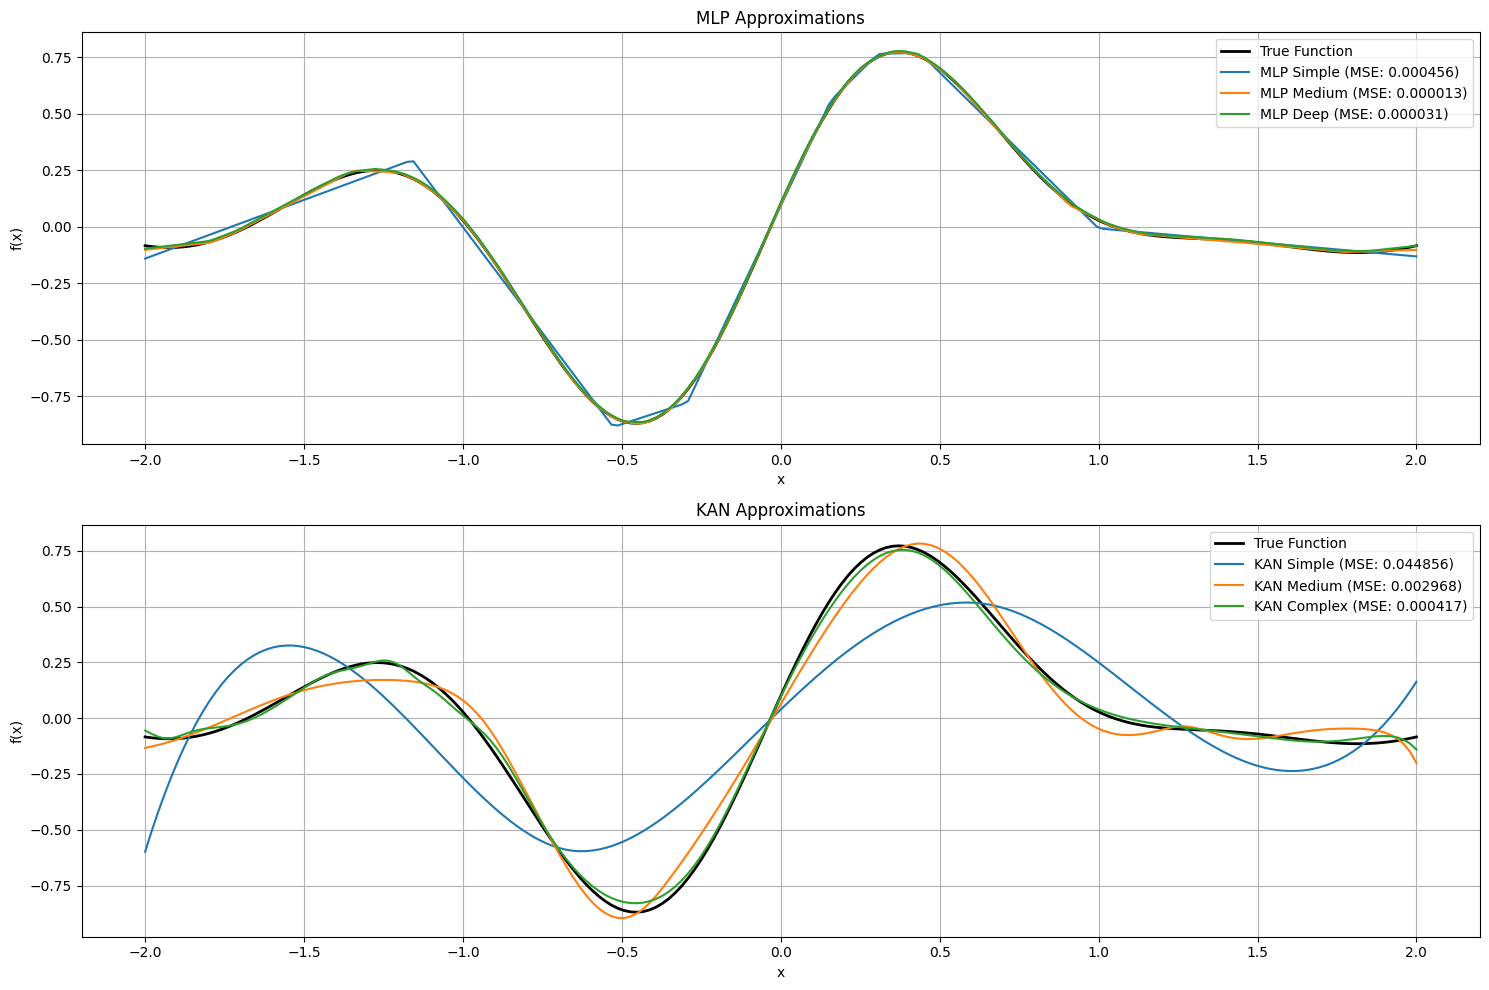

In [11]:
# Визуализация
plt.figure(figsize=(15, 10))

# График для MLP
plt.subplot(2, 1, 1)
plt.plot(x_test, y_test, label="True Function", color="black", linewidth=2)
for i, pred in enumerate(mlp_predictions):
    plt.plot(x_test, pred, label=f"{mlp_configs[i]['name']} (MSE: {mlp_mse[i]:.6f})")
plt.title("MLP Approximations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

# График для KAN
plt.subplot(2, 1, 2)
plt.plot(x_test, y_test, label="True Function", color="black", linewidth=2)
for i, pred in enumerate(kan_predictions):
    plt.plot(x_test, pred, label=f"{kan_configs[i]['name']} (MSE: {kan_mse[i]:.6f})")
plt.title("KAN Approximations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("mlp_kan_comparison.png")

# Вывод символической формулы для лучшей KAN модели
best_kan_idx = np.argmin(kan_mse)
best_kan_model = kan_models[best_kan_idx]
symbolic_formula = best_kan_model.symbolic_formula()[0][0]

# Сохранение символической формулы в файл
with open("kan_symbolic_formula.txt", "w") as f:
    f.write(str(symbolic_formula))

# Вывод MSE для сравнения
print("MLP MSE Scores:")
for i, mse in enumerate(mlp_mse):
    print(f"{mlp_configs[i]['name']}: {mse:.6f}")

print("\nKAN MSE Scores:")
for i, mse in enumerate(kan_mse):
    print(f"{kan_configs[i]['name']}: {mse:.6f}")

print("\nBest KAN Symbolic Formula (saved to kan_symbolic_formula.txt):")
print(symbolic_formula)